# 손과 팔뚝 영역 크롭 EDA

배경의 불필요한 정보를 제거하고 손과 팔뚝 영역만 포함하도록 이미지를 크롭하는 실험을 진행합니다.
데이터 로드 방식은 `eda/EDA.ipynb`를 참고하였습니다.

In [2]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 데이터 경로 설정 (EDA.ipynb 참고)
IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"

In [3]:
# 파일 목록 수집 (EDA.ipynb 참고)
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

pngs = sorted(list(pngs))
jsons = sorted(list(jsons))

print(f"Found {len(pngs)} images and {len(jsons)} labels.")

Found 800 images and 800 labels.


In [4]:
def get_bbox(annotations, padding=100):
    all_points = []
    for ann in annotations:
        points = np.array(ann['points'])
        all_points.append(points)
    
    if not all_points:
        return None
        
    all_points = np.vstack(all_points)
    x_min, y_min = np.min(all_points, axis=0)
    x_max, y_max = np.max(all_points, axis=0)
    
    return int(x_min), int(y_min), int(x_max), int(y_max)

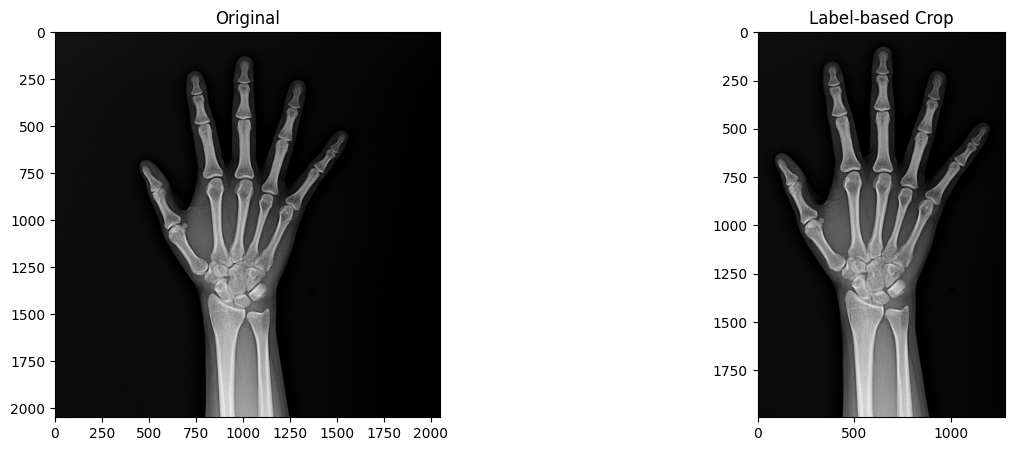

In [5]:
idx = 0
img_path = os.path.join(IMAGE_ROOT, pngs[idx])
json_path = os.path.join(LABEL_ROOT, jsons[idx])

image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

with open(json_path, 'r') as f:
    label_data = json.load(f)

annotations = label_data.get('annotations', [])
bbox = get_bbox(annotations)

if bbox:
    x_min, y_min, x_max, y_max = bbox
    h, w = image.shape
    padding = 100
    
    lx_min = max(0, x_min - padding)
    ly_min = max(0, y_min - padding)
    lx_max = min(w, x_max + padding)
    ly_max = min(h, y_max + padding)

    cropped_label = image[ly_min:ly_max, lx_min:lx_max]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(cropped_label, cmap='gray')
    plt.title("Label-based Crop")
    plt.show()

## Heuristic-based Cropping (For Test Set)

테스트 데이터셋에는 라벨이 없으므로, 이미지 처리를 통해 손 영역을 찾아내는 휴리스틱 방법을 구현합니다.

In [6]:
def get_heuristic_bbox(image, threshold=20, padding=100):
    # 단순 임계값 처리로 배경 분리
    binary = (image > threshold).astype(np.uint8)
    
    # 노이즈 제거를 위한 모폴로지 연산
    kernel = np.ones((5,5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # 가장 큰 컨투어 찾기
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0, 0, image.shape[1], image.shape[0]
    
    # 모든 컨투어를 포함하는 바운딩 박스 계산
    all_cnt = np.concatenate(contours)
    x, y, w_box, h_box = cv2.boundingRect(all_cnt)
    
    img_h, img_w = image.shape
    x_min = max(0, x - padding)
    y_min = max(0, y - padding)
    x_max = min(img_w, x + w_box + padding)
    y_max = min(img_h, y + h_box + padding)
    
    return x_min, y_min, x_max, y_max

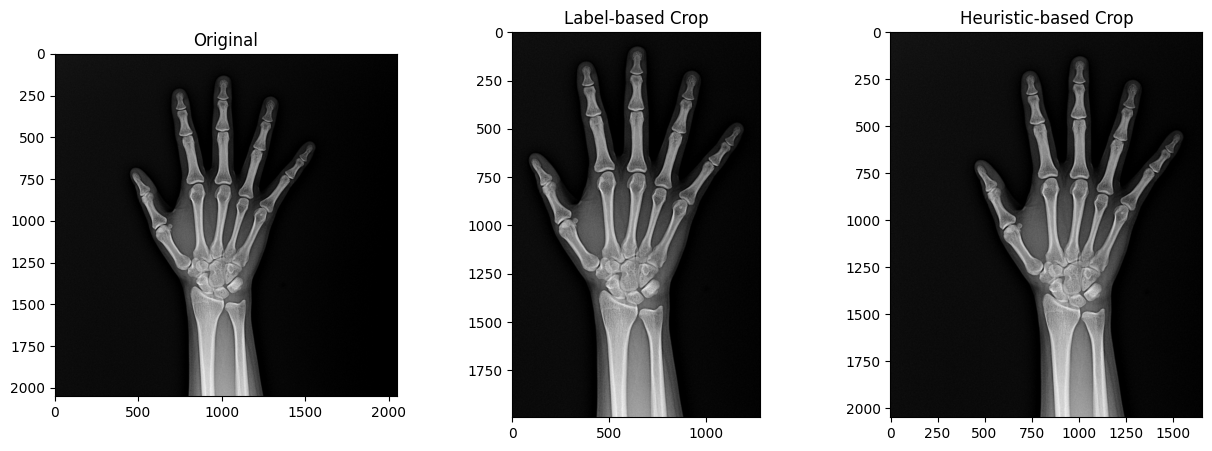

In [7]:
hx_min, hy_min, hx_max, hy_max = get_heuristic_bbox(image)
h_cropped = image[hy_min:hy_max, hx_min:hx_max]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(cropped_label, cmap='gray')
plt.title("Label-based Crop")
plt.subplot(1, 3, 3)
plt.imshow(h_cropped, cmap='gray')
plt.title("Heuristic-based Crop")
plt.show()